In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
from numpy.random import choice, randint
import MeCab
from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext jupyternotify

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>

In [2]:
positive_data_file = "data/amazon_ja/pos.txt"
negative_data_file = "data/amazon_ja/neg.txt"

In [3]:
dic_dir = "/usr/lib/mecab/dic/mecab-ipadic-neologd"
#dic_dir = "/usr/local/lib/mecab/dic/mecab-ipadic-neologd/"
class Tokenizer:
    def __init__(self, dic_dir):
        mecab = MeCab.Tagger("-Ochasen -d {}".format(dic_dir))
        self.parser = mecab.parse
            

    def tokenize(self, text):
        text = text.lower()
        l = [line.split("\t") for line in self.parser(text).split("\n")]
        res = " ".join([i[2] for i in l if len(i) >=4]) # has POS.)
        return res

In [4]:
Tokenizer(dic_dir).tokenize("認めたくないものだな。自分自身の若さ故の過ちというものを。")

'認める たい ない もの だ な 。 自分自身 の 若さ故の過ち という もの を 。'

In [5]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char", lang="En", dic_dir=None):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        if lang == "Ja":
            t = Tokenizer(dic_dir)
            positive_examples = [t.tokenize(s) for s in positive_examples]
            negative_examples = [t.tokenize(s) for s in negative_examples]
        else:
            positive_examples = [s.strip() for s in positive_examples]
            negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    n_pos = len(positive_examples)
    n_neg = len(negative_examples)
    ratio = n_pos/n_neg
    print("# pos: ", n_pos)
    print("# neg: ", n_neg)
    print("pos/neg:", ratio)
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y, ratio

In [6]:
%%notify
level = "char" #"word"
x_text, y, ratio = load_data_and_labels(positive_data_file, negative_data_file, level=level, lang="Ja", dic_dir=dic_dir)

# pos:  62402
# neg:  9060
pos/neg: 6.887637969094922


<IPython.core.display.Javascript object>

In [7]:
long_doc = True

In [8]:
len(x_text)

71462

In [9]:
x_text[0]

' 書 き 込 み 、 読 み 出 し 、 転 送 速 度 、 い ず れ も 満 足 で す 。 1 6 0 0 万 画 素 の コ ン パ ク ト カ メ ラ タ イ プ の デ ジ カ メ に 入 れ て 撮 影 に 使 い 、 撮 影 後 は カ ー ド リ ー ダ に 接 続 し て 、 撮 影 し た 膨 大 な 量 の 画 像 デ ー タ を サ ム ネ イ ル 表 示 に し た り 、 ピ ッ ク ア ッ プ し た 画 像 を コ ピ ペ し た り し て い ま す が 、 と く に ス ト レ ス を 感 じ る こ と な く 、 快 適 に 使 え て い ま す 。 【 a m a z o n . c o . j p 限 定 】 の 個 体 は 、 s d カ ー ド 本 体 が シ ン プ ル な 小 さ い ボ ー ル 紙 に 挟 ま れ て い る だ け 。 梱 包 は 超 シ ン プ ル で す が 、 実 売 価 格 が 安 く 、 性 能 に も 満 足 出 来 て い る の で 買 っ て 良 か っ た と 思 っ て い ま す 。 耐 久 性 は わ か り ま せ ん 。 そ こ は 要 経 過 観 察 で す ね 。 \n '

In [10]:
length_list = np.array([len(r)for r in x_text])

In [11]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,549
1,67
2,179
3,227
4,311


In [12]:
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

,length
count,71462.000000
mean,251.363746
std,328.850754
min,7.000000
50%,171.000000
75%,289.000000
80%,329.000000
90%,471.000000
95%,669.000000
max,17495.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3745f83c8>]],
      dtype=object)

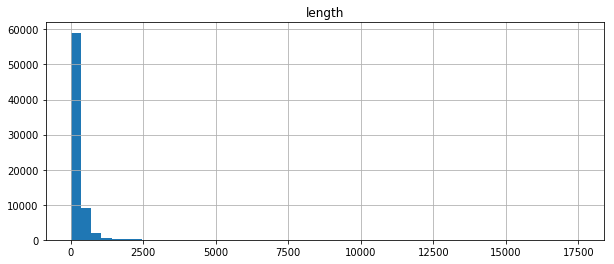

In [13]:
df.hist(bins=50,figsize=(10,4))

In [14]:
max_length = int(df.quantile(0.9)["length"]) #1000
if long_doc:
    print("cut length to ", max_length)
    x_text = [x[:max_length] if len(x) > max_length else x for x in x_text]
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe(percentiles=[0.5,0.75,0.8,0.9,0.95])

cut length to  471


,length
count,71462.000000
mean,210.610730
std,128.956019
min,7.000000
50%,171.000000
75%,289.000000
80%,329.000000
90%,471.000000
95%,471.000000
max,471.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3745fdda0>]],
      dtype=object)

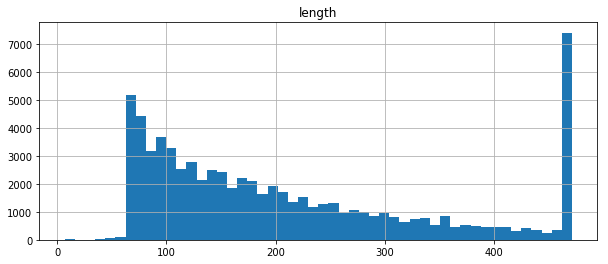

In [15]:
df.hist(bins=50,figsize=(10,4))

In [16]:
vocab_processor = preprocessing.VocabularyProcessor(max_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [17]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [18]:
test_percentage = 0.05

In [19]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 3215
Train/Test split: 67889/3573


<IPython.core.display.Javascript object>

In [20]:
print(x_train.shape)

(67889, 471)


In [21]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [22]:
class RNN:
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size,
                 cell_type, hidden_size, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_text = tf.placeholder(tf.int32, shape=[None, sequence_length], name='input_text')
        self.input_y = tf.placeholder(tf.float32, shape=[None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        l2_loss = tf.constant(0.0)
        text_length = self._length(self.input_text)

        with tf.device('/cpu:0'), tf.name_scope("text-embedding"):
            self.W_text = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W_text")
            self.embedded_chars = tf.nn.embedding_lookup(self.W_text, self.input_text)


        with tf.name_scope("rnn"):
            cell = self._get_cell(hidden_size, cell_type)
            cell = tf.nn.rnn_cell.DropoutWrapper(cell, output_keep_prob=self.dropout_keep_prob)
            all_outputs, _ = tf.nn.dynamic_rnn(cell=cell, inputs=self.embedded_chars, sequence_length=text_length, dtype=tf.float32)
            self.h_outputs = self.last_relevant(all_outputs, text_length)


        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[hidden_size, num_classes], initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.logits = tf.nn.xw_plus_b(self.h_outputs, W, b, name="logits")
            self.predictions = tf.argmax(self.logits, 1, name="predictions")


        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.logits, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, axis=1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name="accuracy")

    @staticmethod
    def _get_cell(hidden_size, cell_type):
        if cell_type == "vanilla":
            return tf.nn.rnn_cell.BasicRNNCell(hidden_size)
        elif cell_type == "lstm":
            return tf.nn.rnn_cell.BasicLSTMCell(hidden_size)
        elif cell_type == "gru":
            return tf.nn.rnn_cell.GRUCell(hidden_size)
        else:
            print("ERROR: '" + cell_type + "' is a wrong cell type !!!")
            return None

    @staticmethod
    def _length(seq):
        relevant = tf.sign(tf.abs(seq))
        length = tf.reduce_sum(relevant, reduction_indices=1)
        length = tf.cast(length, tf.int32)
        return length

    @staticmethod
    def last_relevant(seq, length):
        batch_size = tf.shape(seq)[0]
        max_length = int(seq.get_shape()[1])
        input_size = int(seq.get_shape()[2])
        index = tf.range(0, batch_size) * max_length + (length - 1)
        flat = tf.reshape(seq, [-1, input_size])
        return tf.gather(flat, index)

In [23]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    print("num of epochs: ", num_epochs)
    print("num of batches: ", num_batches_per_epoch)
    print("num of step: ", num_batches_per_epoch*num_epochs)
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [24]:
cell_type="lstm"#"vanilla"
word2vec=None
embedding_dim=300
hidden_size=128
dropout_keep_prob=0.5
l2_reg_lambda=3.0

In [25]:
batch_size = 64
display_every=10
num_epochs = 30            
evaluate_every = 20         
num_checkpoints = 5
learning_rate = 1e-3

allow_soft_placement = True    
log_device_placement = False  

save_checkpoint = True

time_path = datetime.datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
prefix = ""
out_dir = os.path.join(os.path.curdir, "runs",cell_type+"_"+level, time_path, prefix)
print("Writing to {}\n".format(out_dir))

Writing to ./runs/lstm_char/2018_07_21_12_43_14/



In [ ]:
with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
            allow_soft_placement=allow_soft_placement,
            log_device_placement=log_device_placement)
        
        sess = tf.Session(config=session_conf)
        
        with sess.as_default():
            
            
            rnn = RNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=vocab_size,
                embedding_size=embedding_dim,
                cell_type=cell_type,
                hidden_size=hidden_size,
                l2_reg_lambda=l2_reg_lambda
            )


            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(learning_rate)
            grads_and_vars = optimizer.compute_gradients(rnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


            grad_summaries = []
            for g, v in grads_and_vars:
                if g is not None:
                    grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                    sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                    grad_summaries.append(grad_hist_summary)
                    grad_summaries.append(sparsity_summary)
            grad_summaries_merged = tf.summary.merge(grad_summaries)


            loss_summary = tf.summary.scalar("loss", rnn.loss)
            acc_summary = tf.summary.scalar("accuracy", rnn.accuracy)

            train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
            train_summary_dir = os.path.join(out_dir, "summaries", "train")
            train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

            test_summary_op = tf.summary.merge([loss_summary, acc_summary])
            test_summary_dir = os.path.join(out_dir, "summaries", "test")
            test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

            if save_checkpoint:
                checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
                checkpoint_prefix = os.path.join(checkpoint_dir, "model")
                if not os.path.exists(checkpoint_dir):
                    os.makedirs(checkpoint_dir)
                saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
            vocab_processor.save(os.path.join(out_dir, "vocab"))


            sess.run(tf.global_variables_initializer())

            # Pre-trained word2vec
            if word2vec:
                # initial matrix with random uniform
                initW = np.random.uniform(-0.25, 0.25, (len(text_vocab_processor.vocabulary_), embedding_dim))
                # load any vectors from the word2vec
                print("Load word2vec file {0}".format(word2vec))
                with open(word2vec, "rb") as f:
                    header = f.readline()
                    vocab_size, layer1_size = map(int, header.split())
                    binary_len = np.dtype('float32').itemsize * layer1_size
                    for line in range(vocab_size):
                        word = []
                        while True:
                            ch = f.read(1).decode('latin-1')
                            if ch == ' ':
                                word = ''.join(word)
                                break
                            if ch != '\n':
                                word.append(ch)
                        idx = text_vocab_processor.vocabulary_.get(word)
                        if idx != 0:
                            initW[idx] = np.fromstring(f.read(binary_len), dtype='float32')
                        else:
                            f.read(binary_len)
                sess.run(rnn.W_text.assign(initW))
                print("Success to load pre-trained word2vec model!\n")


            batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)

            for batch in batches:
                x_batch, y_batch = zip(*batch)
                feed_dict = {
                    rnn.input_text: x_batch,
                    rnn.input_y: y_batch,
                    rnn.dropout_keep_prob: dropout_keep_prob
                }
                _, step, summaries, loss, accuracy = sess.run(
                    [train_op, global_step, train_summary_op, rnn.loss, rnn.accuracy], feed_dict)
                train_summary_writer.add_summary(summaries, step)

                if step % display_every == 0:
                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    print("\nEvaluation:")
                    feed_dict_test = {
                        rnn.input_text: x_test,
                        rnn.input_y: y_test,
                        rnn.dropout_keep_prob: 1.0
                    }
                    summaries_test, loss, accuracy = sess.run([test_summary_op, rnn.loss, rnn.accuracy], feed_dict_test)
                    test_summary_writer.add_summary(summaries_test, step)

                    time_str = datetime.datetime.now().isoformat()
                    print("{}: step {}, loss {:g}, acc {:g}\n".format(time_str, step, loss, accuracy))

                if step % evaluate_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=step)
                    print("Saved model checkpoint to {}\n".format(path))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


INFO:tensorflow:Summary name text-embedding/W_text:0/grad/hist is illegal; using text-embedding/W_text_0/grad/hist instead.
INFO:tensorflow:Summary name text-embedding/W_text:0/grad/sparsity is illegal; using text-embedding/W_text_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/hist is illegal; using rnn/basic_lstm_cell/kernel_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/kernel:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/kernel_0/grad/sparsity instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/hist is illegal; using rnn/basic_lstm_cell/bias_0/grad/hist instead.
INFO:tensorflow:Summary name rnn/basic_lstm_cell/bias:0/grad/sparsity is illegal; using rnn/basic_lstm_cell/bias_0/grad/sparsity instead.
INFO:tensorflow:Summary name W:0/grad/hist is illegal; using W_0/grad/hist instead.
INFO:tensorflow:Summary name W:0/grad/sparsity is illegal; using W_0/grad/sparsity instead.
INFO:tensorflow:Summary 

2018-07-21T12:45:58.353860: step 440, loss 0.255981, acc 0.9375

Evaluation:
2018-07-21T12:45:58.802935: step 440, loss 0.332736, acc 0.900084

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-440

2018-07-21T12:46:02.228107: step 450, loss 0.275475, acc 0.921875
2018-07-21T12:46:05.461367: step 460, loss 0.429176, acc 0.859375

Evaluation:
2018-07-21T12:46:05.904018: step 460, loss 0.331102, acc 0.900644

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-460

2018-07-21T12:46:09.340692: step 470, loss 0.293073, acc 0.921875
2018-07-21T12:46:12.653100: step 480, loss 0.256853, acc 0.953125

Evaluation:
2018-07-21T12:46:13.096744: step 480, loss 0.32841, acc 0.900364

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-480

2018-07-21T12:46:16.549044: step 490, loss 0.303738, acc 0.90625
20

2018-07-21T12:48:54.528090: step 930, loss 0.392508, acc 0.859375
2018-07-21T12:48:57.952270: step 940, loss 0.351986, acc 0.90625

Evaluation:
2018-07-21T12:48:58.396015: step 940, loss 0.311601, acc 0.90988

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-940

2018-07-21T12:49:01.930024: step 950, loss 0.341765, acc 0.890625
2018-07-21T12:49:05.268281: step 960, loss 0.321759, acc 0.90625

Evaluation:
2018-07-21T12:49:05.710703: step 960, loss 0.30676, acc 0.912399

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-960

2018-07-21T12:49:09.032844: step 970, loss 0.212194, acc 0.96875
2018-07-21T12:49:12.324735: step 980, loss 0.44168, acc 0.8125

Evaluation:
2018-07-21T12:49:12.764438: step 980, loss 0.311195, acc 0.910999

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-980

2018-0

2018-07-21T12:51:52.771087: step 1430, loss 0.335378, acc 0.921875
2018-07-21T12:51:55.708776: step 1440, loss 0.204853, acc 0.953125

Evaluation:
2018-07-21T12:51:56.141669: step 1440, loss 0.291233, acc 0.914358

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-1440

2018-07-21T12:51:59.209932: step 1450, loss 0.281595, acc 0.859375
2018-07-21T12:52:02.209472: step 1460, loss 0.246621, acc 0.953125

Evaluation:
2018-07-21T12:52:02.650161: step 1460, loss 0.300852, acc 0.904842

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-1460

2018-07-21T12:52:05.791671: step 1470, loss 0.250489, acc 0.921875
2018-07-21T12:52:08.836342: step 1480, loss 0.327266, acc 0.90625

Evaluation:
2018-07-21T12:52:09.269036: step 1480, loss 0.309946, acc 0.906801

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints

2018-07-21T12:54:27.294365: step 1920, loss 0.285575, acc 0.918276

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-1920

2018-07-21T12:54:30.111133: step 1930, loss 0.304111, acc 0.890625
2018-07-21T12:54:33.041609: step 1940, loss 0.276567, acc 0.90625

Evaluation:
2018-07-21T12:54:33.480594: step 1940, loss 0.292773, acc 0.916037

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-1940

2018-07-21T12:54:36.361813: step 1950, loss 0.366579, acc 0.90625
2018-07-21T12:54:39.112611: step 1960, loss 0.26134, acc 0.921875

Evaluation:
2018-07-21T12:54:39.543203: step 1960, loss 0.285534, acc 0.918836

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-1960

2018-07-21T12:54:42.357019: step 1970, loss 0.210022, acc 0.953125
2018-07-21T12:54:45.121810: step 1980, loss 0.405977, acc 0.90625

Ev

2018-07-21T12:56:54.629667: step 2410, loss 0.226592, acc 0.953125
2018-07-21T12:56:57.307215: step 2420, loss 0.438249, acc 0.875

Evaluation:
2018-07-21T12:56:57.728206: step 2420, loss 0.274152, acc 0.925833

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-2420

2018-07-21T12:57:00.418388: step 2430, loss 0.22216, acc 0.96875
2018-07-21T12:57:03.084530: step 2440, loss 0.395378, acc 0.84375

Evaluation:
2018-07-21T12:57:03.515716: step 2440, loss 0.458484, acc 0.784495

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-2440

2018-07-21T12:57:06.201548: step 2450, loss 0.305548, acc 0.921875
2018-07-21T12:57:08.854345: step 2460, loss 0.308885, acc 0.921875

Evaluation:
2018-07-21T12:57:09.276799: step 2460, loss 0.315863, acc 0.914078

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/mode

2018-07-21T12:59:15.998354: step 2900, loss 0.27776, acc 0.923314

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-2900

2018-07-21T12:59:18.697100: step 2910, loss 0.333047, acc 0.921875
2018-07-21T12:59:21.290825: step 2920, loss 0.206494, acc 0.953125

Evaluation:
2018-07-21T12:59:21.707814: step 2920, loss 0.272972, acc 0.929751

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-2920

2018-07-21T12:59:24.440828: step 2930, loss 0.204012, acc 0.953125
2018-07-21T12:59:27.045498: step 2940, loss 0.271983, acc 0.953125

Evaluation:
2018-07-21T12:59:27.465926: step 2940, loss 0.27788, acc 0.923034

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-2940

2018-07-21T12:59:30.162419: step 2950, loss 0.205729, acc 0.9375
2018-07-21T12:59:32.764040: step 2960, loss 0.372872, acc 0.875

Evalu

2018-07-21T13:01:36.386689: step 3390, loss 0.24288, acc 0.9375
2018-07-21T13:01:39.018150: step 3400, loss 0.293306, acc 0.921875

Evaluation:
2018-07-21T13:01:39.448261: step 3400, loss 0.273244, acc 0.925833

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-3400

2018-07-21T13:01:42.137934: step 3410, loss 0.192023, acc 0.984375
2018-07-21T13:01:44.752632: step 3420, loss 0.291358, acc 0.921875

Evaluation:
2018-07-21T13:01:45.168864: step 3420, loss 0.272672, acc 0.924713

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-3420

2018-07-21T13:01:47.854482: step 3430, loss 0.274742, acc 0.921875
2018-07-21T13:01:50.490074: step 3440, loss 0.191856, acc 0.984375

Evaluation:
2018-07-21T13:01:50.912501: step 3440, loss 0.275605, acc 0.924993

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/m

2018-07-21T13:03:58.448231: step 3890, loss 0.199814, acc 0.96875
2018-07-21T13:04:00.978108: step 3900, loss 0.25338, acc 0.9375

Evaluation:
2018-07-21T13:04:01.406210: step 3900, loss 0.268085, acc 0.928352

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-3900

2018-07-21T13:04:04.049765: step 3910, loss 0.231019, acc 0.96875
2018-07-21T13:04:06.692636: step 3920, loss 0.290438, acc 0.9375

Evaluation:
2018-07-21T13:04:07.108353: step 3920, loss 0.267006, acc 0.928072

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-3920

2018-07-21T13:04:09.861496: step 3930, loss 0.275275, acc 0.953125
2018-07-21T13:04:12.431162: step 3940, loss 0.30306, acc 0.875

Evaluation:
2018-07-21T13:04:12.848447: step 3940, loss 0.265744, acc 0.930031

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-394

2018-07-21T13:06:20.048304: step 4390, loss 0.236105, acc 0.9375
2018-07-21T13:06:22.649806: step 4400, loss 0.30691, acc 0.921875

Evaluation:
2018-07-21T13:06:23.079716: step 4400, loss 0.315738, acc 0.905122

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-4400

2018-07-21T13:06:25.732721: step 4410, loss 0.4331, acc 0.859375
2018-07-21T13:06:28.300400: step 4420, loss 0.314907, acc 0.921875

Evaluation:
2018-07-21T13:06:28.739681: step 4420, loss 0.284869, acc 0.918836

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-4420

2018-07-21T13:06:31.334217: step 4430, loss 0.179115, acc 0.984375
2018-07-21T13:06:33.905870: step 4440, loss 0.21991, acc 0.984375

Evaluation:
2018-07-21T13:06:34.321878: step 4440, loss 0.277074, acc 0.923594

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/mode

2018-07-21T13:08:41.384623: step 4890, loss 0.322641, acc 0.84375
2018-07-21T13:08:43.978595: step 4900, loss 0.182274, acc 0.96875

Evaluation:
2018-07-21T13:08:44.404802: step 4900, loss 0.263623, acc 0.927792

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-4900

2018-07-21T13:08:47.046262: step 4910, loss 0.240605, acc 0.953125
2018-07-21T13:08:49.650250: step 4920, loss 0.236398, acc 0.953125

Evaluation:
2018-07-21T13:08:50.068400: step 4920, loss 0.264652, acc 0.929751

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-4920

2018-07-21T13:08:52.722185: step 4930, loss 0.300606, acc 0.921875
2018-07-21T13:08:55.290813: step 4940, loss 0.25175, acc 0.96875

Evaluation:
2018-07-21T13:08:55.712318: step 4940, loss 0.267252, acc 0.926113

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/mo

2018-07-21T13:11:00.332592: step 5380, loss 0.268652, acc 0.928352

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-5380

2018-07-21T13:11:02.961535: step 5390, loss 0.198865, acc 0.984375
2018-07-21T13:11:05.529709: step 5400, loss 0.216379, acc 0.96875

Evaluation:
2018-07-21T13:11:05.951497: step 5400, loss 0.263639, acc 0.928072

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-5400

2018-07-21T13:11:08.587153: step 5410, loss 0.208695, acc 0.953125
2018-07-21T13:11:11.149401: step 5420, loss 0.185785, acc 0.96875

Evaluation:
2018-07-21T13:11:11.570716: step 5420, loss 0.267765, acc 0.928352

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-5420

2018-07-21T13:11:14.223123: step 5430, loss 0.172432, acc 1
2018-07-21T13:11:16.798515: step 5440, loss 0.170371, acc 0.96875

Evaluati

2018-07-21T13:13:18.799429: step 5870, loss 0.284154, acc 0.90625
2018-07-21T13:13:21.379438: step 5880, loss 0.341926, acc 0.921875

Evaluation:
2018-07-21T13:13:21.801488: step 5880, loss 0.256116, acc 0.935069

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-5880

2018-07-21T13:13:24.452154: step 5890, loss 0.237186, acc 0.9375
2018-07-21T13:13:27.018947: step 5900, loss 0.199514, acc 0.9375

Evaluation:
2018-07-21T13:13:27.444931: step 5900, loss 0.256712, acc 0.93143

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-5900

2018-07-21T13:13:30.123771: step 5910, loss 0.232272, acc 0.9375
2018-07-21T13:13:32.684471: step 5920, loss 0.228272, acc 0.9375

Evaluation:
2018-07-21T13:13:33.110204: step 5920, loss 0.267336, acc 0.93087

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-592

2018-07-21T13:15:40.263326: step 6370, loss 0.207892, acc 0.96875
2018-07-21T13:15:42.840917: step 6380, loss 0.264305, acc 0.90625

Evaluation:
2018-07-21T13:15:43.263669: step 6380, loss 0.25615, acc 0.933669

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-6380

2018-07-21T13:15:45.927912: step 6390, loss 0.23952, acc 0.953125
2018-07-21T13:15:48.534719: step 6400, loss 0.34507, acc 0.859375

Evaluation:
2018-07-21T13:15:48.957546: step 6400, loss 0.284313, acc 0.927792

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-6400

2018-07-21T13:15:51.637875: step 6410, loss 0.24154, acc 0.953125
2018-07-21T13:15:54.220740: step 6420, loss 0.207241, acc 0.96875

Evaluation:
2018-07-21T13:15:54.636564: step 6420, loss 0.266872, acc 0.935348

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model

2018-07-21T13:17:58.977665: step 6860, loss 0.255027, acc 0.933949

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-6860

2018-07-21T13:18:01.627844: step 6870, loss 0.151373, acc 0.984375
2018-07-21T13:18:04.243426: step 6880, loss 0.212813, acc 0.9375

Evaluation:
2018-07-21T13:18:04.677463: step 6880, loss 0.254801, acc 0.935348

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-6880

2018-07-21T13:18:07.350130: step 6890, loss 0.185647, acc 0.984375
2018-07-21T13:18:09.899828: step 6900, loss 0.259132, acc 0.921875

Evaluation:
2018-07-21T13:18:10.322275: step 6900, loss 0.252491, acc 0.935348

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-6900

2018-07-21T13:18:12.941170: step 6910, loss 0.179884, acc 0.96875
2018-07-21T13:18:15.510029: step 6920, loss 0.242433, acc 0.921875

E

2018-07-21T13:20:17.362901: step 7350, loss 0.255448, acc 0.953125
2018-07-21T13:20:19.923278: step 7360, loss 0.234163, acc 0.953125

Evaluation:
2018-07-21T13:20:20.341833: step 7360, loss 0.258602, acc 0.927792

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-7360

2018-07-21T13:20:22.993408: step 7370, loss 0.284077, acc 0.9375
2018-07-21T13:20:25.562382: step 7380, loss 0.205054, acc 0.96875

Evaluation:
2018-07-21T13:20:25.984921: step 7380, loss 0.258222, acc 0.934789

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-7380

2018-07-21T13:20:28.602682: step 7390, loss 0.128592, acc 1
2018-07-21T13:20:31.174281: step 7400, loss 0.220925, acc 0.953125

Evaluation:
2018-07-21T13:20:31.593701: step 7400, loss 0.251748, acc 0.93171

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-740

2018-07-21T13:22:38.718320: step 7850, loss 0.207949, acc 0.96875
2018-07-21T13:22:41.311577: step 7860, loss 0.188577, acc 0.984375

Evaluation:
2018-07-21T13:22:41.748558: step 7860, loss 0.250428, acc 0.93199

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-7860

2018-07-21T13:22:44.425199: step 7870, loss 0.15452, acc 0.984375
2018-07-21T13:22:47.055387: step 7880, loss 0.224123, acc 0.9375

Evaluation:
2018-07-21T13:22:47.478622: step 7880, loss 0.255255, acc 0.93283

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-7880

2018-07-21T13:22:50.149019: step 7890, loss 0.227308, acc 0.953125
2018-07-21T13:22:52.703908: step 7900, loss 0.250664, acc 0.921875

Evaluation:
2018-07-21T13:22:53.123604: step 7900, loss 0.251611, acc 0.93199

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model

2018-07-21T13:24:57.280290: step 8340, loss 0.247893, acc 0.939826

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-8340

2018-07-21T13:24:59.969780: step 8350, loss 0.251955, acc 0.921875
2018-07-21T13:25:02.545609: step 8360, loss 0.154357, acc 0.96875

Evaluation:
2018-07-21T13:25:02.973778: step 8360, loss 0.247286, acc 0.938987

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-8360

2018-07-21T13:25:05.617374: step 8370, loss 0.25045, acc 0.96875
2018-07-21T13:25:08.203525: step 8380, loss 0.210451, acc 0.9375

Evaluation:
2018-07-21T13:25:08.625261: step 8380, loss 0.245193, acc 0.938707

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-8380

2018-07-21T13:25:11.273035: step 8390, loss 0.172669, acc 0.984375
2018-07-21T13:25:13.843268: step 8400, loss 0.307707, acc 0.90625

Eval

2018-07-21T13:27:15.875348: step 8830, loss 0.295017, acc 0.890625
2018-07-21T13:27:18.443549: step 8840, loss 0.151132, acc 0.984375

Evaluation:
2018-07-21T13:27:18.870650: step 8840, loss 0.248474, acc 0.937867

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-8840

2018-07-21T13:27:21.521351: step 8850, loss 0.169068, acc 0.984375
2018-07-21T13:27:24.093065: step 8860, loss 0.263773, acc 0.9375

Evaluation:
2018-07-21T13:27:24.518390: step 8860, loss 0.285206, acc 0.910999

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-8860

2018-07-21T13:27:27.141418: step 8870, loss 0.195088, acc 0.9375
2018-07-21T13:27:29.722341: step 8880, loss 0.318309, acc 0.890625

Evaluation:
2018-07-21T13:27:30.142314: step 8880, loss 0.25322, acc 0.935908

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/mod

2018-07-21T13:29:37.218394: step 9330, loss 0.258266, acc 0.921875
2018-07-21T13:29:39.804585: step 9340, loss 0.164044, acc 0.96875

Evaluation:
2018-07-21T13:29:40.220266: step 9340, loss 0.251078, acc 0.933389

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-9340

2018-07-21T13:29:42.882989: step 9350, loss 0.155236, acc 0.984375
2018-07-21T13:29:45.472977: step 9360, loss 0.178649, acc 0.984375

Evaluation:
2018-07-21T13:29:45.894005: step 9360, loss 0.249591, acc 0.933949

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-9360

2018-07-21T13:29:48.549175: step 9370, loss 0.216885, acc 0.953125
2018-07-21T13:29:51.144776: step 9380, loss 0.231918, acc 0.953125

Evaluation:
2018-07-21T13:29:51.569849: step 9380, loss 0.254818, acc 0.935348

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints

2018-07-21T13:31:56.222789: step 9820, loss 0.250913, acc 0.935908

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-9820

2018-07-21T13:31:58.860125: step 9830, loss 0.164787, acc 1
2018-07-21T13:32:01.427897: step 9840, loss 0.266579, acc 0.953125

Evaluation:
2018-07-21T13:32:01.848487: step 9840, loss 0.253783, acc 0.935628

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-9840

2018-07-21T13:32:04.495325: step 9850, loss 0.195576, acc 0.984375
2018-07-21T13:32:07.052100: step 9860, loss 0.129057, acc 1

Evaluation:
2018-07-21T13:32:07.480488: step 9860, loss 0.244687, acc 0.941226

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-9860

2018-07-21T13:32:10.132985: step 9870, loss 0.151117, acc 0.984375
2018-07-21T13:32:12.712896: step 9880, loss 0.143384, acc 0.984375

Evaluation:


2018-07-21T13:34:14.804134: step 10310, loss 0.198312, acc 0.96875
2018-07-21T13:34:17.402656: step 10320, loss 0.193653, acc 0.96875

Evaluation:
2018-07-21T13:34:17.822490: step 10320, loss 0.249839, acc 0.938987

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-10320

2018-07-21T13:34:20.475437: step 10330, loss 0.226094, acc 0.953125
2018-07-21T13:34:23.070108: step 10340, loss 0.182689, acc 0.953125

Evaluation:
2018-07-21T13:34:23.500487: step 10340, loss 0.258648, acc 0.930031

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-10340

2018-07-21T13:34:26.193230: step 10350, loss 0.247753, acc 0.9375
2018-07-21T13:34:28.778829: step 10360, loss 0.220453, acc 0.96875

Evaluation:
2018-07-21T13:34:29.196390: step 10360, loss 0.251944, acc 0.938707

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/chec

2018-07-21T13:36:33.165492: step 10800, loss 0.195278, acc 0.984375

Evaluation:
2018-07-21T13:36:33.586858: step 10800, loss 0.253498, acc 0.934229

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-10800

2018-07-21T13:36:36.253682: step 10810, loss 0.196518, acc 0.96875
2018-07-21T13:36:38.826637: step 10820, loss 0.187146, acc 0.984375

Evaluation:
2018-07-21T13:36:39.252121: step 10820, loss 0.250055, acc 0.937867

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-10820

2018-07-21T13:36:41.914257: step 10830, loss 0.16898, acc 0.96875
2018-07-21T13:36:44.466804: step 10840, loss 0.152554, acc 0.984375

Evaluation:
2018-07-21T13:36:44.886956: step 10840, loss 0.253502, acc 0.935348

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-10840

2018-07-21T13:36:47.519897: step 10850, loss 

2018-07-21T13:38:49.241521: step 11280, loss 0.244283, acc 0.937867

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-11280

2018-07-21T13:38:51.873337: step 11290, loss 0.219406, acc 0.9375
2018-07-21T13:38:54.412401: step 11300, loss 0.188123, acc 0.96875

Evaluation:
2018-07-21T13:38:54.841510: step 11300, loss 0.244269, acc 0.937867

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-11300

2018-07-21T13:38:57.487900: step 11310, loss 0.234958, acc 0.9375
2018-07-21T13:39:00.065406: step 11320, loss 0.190766, acc 0.984375

Evaluation:
2018-07-21T13:39:00.497189: step 11320, loss 0.244265, acc 0.936748

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-11320

2018-07-21T13:39:03.188416: step 11330, loss 0.246751, acc 0.96875
2018-07-21T13:39:05.784760: step 11340, loss 0.205905, acc 0.

2018-07-21T13:41:07.771146: step 11770, loss 0.176451, acc 0.984375
2018-07-21T13:41:10.364982: step 11780, loss 0.217181, acc 0.953125

Evaluation:
2018-07-21T13:41:10.792206: step 11780, loss 0.250412, acc 0.938707

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-11780

2018-07-21T13:41:13.459058: step 11790, loss 0.169822, acc 0.96875
2018-07-21T13:41:16.042609: step 11800, loss 0.169394, acc 0.953125

Evaluation:
2018-07-21T13:41:16.467225: step 11800, loss 0.250986, acc 0.938707

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-11800

2018-07-21T13:41:19.142496: step 11810, loss 0.254127, acc 0.921875
2018-07-21T13:41:21.697062: step 11820, loss 0.171215, acc 0.96875

Evaluation:
2018-07-21T13:41:22.117370: step 11820, loss 0.251944, acc 0.933669

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/c

2018-07-21T13:43:25.837758: step 12260, loss 0.224435, acc 0.953125

Evaluation:
2018-07-21T13:43:26.259572: step 12260, loss 0.254907, acc 0.936748

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12260

2018-07-21T13:43:28.911380: step 12270, loss 0.15133, acc 0.984375
2018-07-21T13:43:31.455161: step 12280, loss 0.235099, acc 0.921875

Evaluation:
2018-07-21T13:43:31.874624: step 12280, loss 0.273171, acc 0.926672

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12280

2018-07-21T13:43:34.531554: step 12290, loss 0.171304, acc 0.984375
2018-07-21T13:43:37.117493: step 12300, loss 0.146821, acc 1

Evaluation:
2018-07-21T13:43:37.539861: step 12300, loss 0.250442, acc 0.936188

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12300

2018-07-21T13:43:40.170271: step 12310, loss 0.253

2018-07-21T13:45:41.724679: step 12740, loss 0.253362, acc 0.936748

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12740

2018-07-21T13:45:44.370439: step 12750, loss 0.289818, acc 0.90625
2018-07-21T13:45:46.952515: step 12760, loss 0.197045, acc 0.953125

Evaluation:
2018-07-21T13:45:47.375923: step 12760, loss 0.258456, acc 0.93255

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12760

2018-07-21T13:45:50.013267: step 12770, loss 0.193566, acc 0.96875
2018-07-21T13:45:52.573800: step 12780, loss 0.201953, acc 0.984375

Evaluation:
2018-07-21T13:45:53.004330: step 12780, loss 0.254842, acc 0.935069

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-12780

2018-07-21T13:45:55.662331: step 12790, loss 0.219834, acc 0.96875
2018-07-21T13:45:58.280652: step 12800, loss 0.170055, acc 

2018-07-21T13:48:00.040970: step 13230, loss 0.205898, acc 0.9375
2018-07-21T13:48:02.633073: step 13240, loss 0.179362, acc 0.984375

Evaluation:
2018-07-21T13:48:03.062347: step 13240, loss 0.24675, acc 0.938147

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-13240

2018-07-21T13:48:05.708078: step 13250, loss 0.151003, acc 0.984375
2018-07-21T13:48:08.293280: step 13260, loss 0.208038, acc 0.96875

Evaluation:
2018-07-21T13:48:08.713266: step 13260, loss 0.247956, acc 0.937308

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-13260

2018-07-21T13:48:11.363007: step 13270, loss 0.173705, acc 0.984375
2018-07-21T13:48:13.931607: step 13280, loss 0.154668, acc 0.984375

Evaluation:
2018-07-21T13:48:14.353052: step 13280, loss 0.243965, acc 0.938147

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/che

2018-07-21T13:50:18.098385: step 13720, loss 0.206343, acc 0.96875

Evaluation:
2018-07-21T13:50:18.516687: step 13720, loss 0.252387, acc 0.936468

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-13720

2018-07-21T13:50:21.186666: step 13730, loss 0.181816, acc 0.984375
2018-07-21T13:50:23.782599: step 13740, loss 0.176239, acc 0.984375

Evaluation:
2018-07-21T13:50:24.204566: step 13740, loss 0.251741, acc 0.938427

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-13740

2018-07-21T13:50:26.840029: step 13750, loss 0.200447, acc 0.96875
2018-07-21T13:50:29.517693: step 13760, loss 0.183547, acc 0.984375

Evaluation:
2018-07-21T13:50:29.945948: step 13760, loss 0.24998, acc 0.937308

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-13760

2018-07-21T13:50:32.568975: step 13770, loss 

2018-07-21T13:52:34.284899: step 14200, loss 0.254087, acc 0.934509

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-14200

2018-07-21T13:52:36.946927: step 14210, loss 0.219061, acc 0.953125
2018-07-21T13:52:39.526772: step 14220, loss 0.180633, acc 0.984375

Evaluation:
2018-07-21T13:52:39.957302: step 14220, loss 0.258944, acc 0.93087

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-14220

2018-07-21T13:52:42.592208: step 14230, loss 0.161752, acc 1
2018-07-21T13:52:45.171631: step 14240, loss 0.140253, acc 1

Evaluation:
2018-07-21T13:52:45.596940: step 14240, loss 0.257948, acc 0.93171

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-14240

2018-07-21T13:52:48.255687: step 14250, loss 0.130085, acc 1
2018-07-21T13:52:50.822665: step 14260, loss 0.184582, acc 0.96875

Evaluation

2018-07-21T13:54:52.308203: step 14690, loss 0.214884, acc 0.9375
2018-07-21T13:54:54.855666: step 14700, loss 0.124221, acc 1

Evaluation:
2018-07-21T13:54:55.278050: step 14700, loss 0.255183, acc 0.938147

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-14700

2018-07-21T13:54:57.921440: step 14710, loss 0.224736, acc 0.96875
2018-07-21T13:55:00.482956: step 14720, loss 0.191013, acc 0.953125

Evaluation:
2018-07-21T13:55:00.913086: step 14720, loss 0.251192, acc 0.936468

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-14720

2018-07-21T13:55:03.589210: step 14730, loss 0.172165, acc 0.953125
2018-07-21T13:55:06.195109: step 14740, loss 0.251625, acc 0.9375

Evaluation:
2018-07-21T13:55:06.611927: step 14740, loss 0.248119, acc 0.937028

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints

2018-07-21T13:57:10.624691: step 15180, loss 0.176015, acc 0.984375

Evaluation:
2018-07-21T13:57:11.046206: step 15180, loss 0.246799, acc 0.942345

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15180

2018-07-21T13:57:13.726958: step 15190, loss 0.156413, acc 0.984375
2018-07-21T13:57:16.278856: step 15200, loss 0.164763, acc 0.984375

Evaluation:
2018-07-21T13:57:16.706248: step 15200, loss 0.245469, acc 0.940386

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15200

2018-07-21T13:57:19.369200: step 15210, loss 0.143704, acc 0.984375
2018-07-21T13:57:21.925606: step 15220, loss 0.234479, acc 0.953125

Evaluation:
2018-07-21T13:57:22.353431: step 15220, loss 0.249294, acc 0.937587

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15220

2018-07-21T13:57:25.021723: step 15230, lo

2018-07-21T13:59:26.701984: step 15660, loss 0.249075, acc 0.938707

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15660

2018-07-21T13:59:29.354698: step 15670, loss 0.202859, acc 0.953125
2018-07-21T13:59:31.920102: step 15680, loss 0.201367, acc 0.96875

Evaluation:
2018-07-21T13:59:32.339451: step 15680, loss 0.252589, acc 0.937308

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15680

2018-07-21T13:59:35.009451: step 15690, loss 0.180005, acc 0.96875
2018-07-21T13:59:37.576872: step 15700, loss 0.134651, acc 1

Evaluation:
2018-07-21T13:59:37.994612: step 15700, loss 0.245522, acc 0.940106

Saved model checkpoint to /home/ubuntu/Workspace/char_level_cnn/runs/lstm_char/2018_07_21_12_43_14/checkpoints/model-15700

2018-07-21T13:59:40.644066: step 15710, loss 0.176005, acc 0.984375
2018-07-21T13:59:43.235899: step 15720, loss 0.159825, acc 1

Ev